### Imports

In [1]:

import time
import pickle

import math
import random
import networkx as nx
import numpy as np
import pandas as pd

import seaborn as sns
from pprint import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.colors
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

import torch
print(f'PyTorch version: {torch.__version__}, CUDA version: {torch.version.cuda}')

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

PyTorch version: 2.1.0+cu121, CUDA version: 12.1


### Data preparation

In [2]:
# events_file_path = '/storage/MUonE/milosz/events2D_3stat_1.pickle'
events_file_path = '/storage/MUonE/mwolter/events2D_NormalSample_3.pickle'

#### Constants

In [3]:
z_scale = 100.

x_layers = [18.0, 89.5, 118.0, 189.5, 218.0, 289.5]      # z-coordinates of layers measuring x
y_layers = [21.0, 93.0, 122.0, 194.0, 222.0, 294.0]      # z-coordinates of layers measuring y
stereo_layers = [55.4, 56.7, 155.4, 156.7, 255.4, 256.7] # z-coordinates of layers measuring u or v

all_layers = sorted(x_layers + y_layers + stereo_layers)

#### Data load

In [4]:
# Function to get number of layer based on z-coordinate
def z_to_layer(z):
    differences = [abs(z - layer) for layer in all_layers]
    closest_index = differences.index(min(differences))
    return closest_index


# Function to get type of layer based on z-coordinate
def layer_type(z):
    layers = [(layer, 'x') for layer in x_layers] + \
             [(layer, 'y') for layer in y_layers] + \
             [(layer, 'stereo') for layer in stereo_layers]

    closest_layer = min(layers, key=lambda x: abs(x[0] - z))
    
    return closest_layer[1]


# Function to calculate chi-square of fit to filter out broken events
def check_ch2(event):
    zx_mu, zx_e, x_mu, x_e, zy_mu, zy_e, y_mu, y_e = [], [], [], [], [], [], [], []
    
    for hit in event:
        if layer_type(hit[0]) == 'x' and hit[0] < 300:
            if hit[2] in [0,1]:
                zx_mu.append(hit[0])
                x_mu.append(hit[1])
            else:
                zx_e.append(hit[0])
                x_e.append(hit[1])
                
        if layer_type(hit[0]) == 'y' and hit[0] < 300:
            if hit[2] in [0,1]:
                zy_mu.append(hit[0])
                y_mu.append(hit[1])
            else:
                zy_e.append(hit[0])
                y_e.append(hit[1])
                
    px_mu = np.polyfit(zx_mu, x_mu, 1)
    chi_squared_x_mu = np.sum((np.polyval(px_mu, zx_mu) - x_mu) ** 2)
    
    py_mu = np.polyfit(zy_mu, y_mu, 1)
    chi_squared_y_mu = np.sum((np.polyval(py_mu, zy_mu) - y_mu) ** 2)
    
    px_e = np.polyfit(zx_e, x_e, 1)
    chi_squared_x_e = np.sum((np.polyval(px_e, zx_e) - x_e) ** 2)
    
    py_e = np.polyfit(zy_e, y_e, 1)
    chi_squared_y_e = np.sum((np.polyval(py_e, zy_e) - y_e) ** 2)
    
    return max(chi_squared_x_mu, chi_squared_y_mu, chi_squared_x_e, chi_squared_y_e)

In [ ]:
def readMUonE(minimal_number_of_hits=30, filter_chi2=True, filter_duplication=False):
    with open(events_file_path, mode='rb') as events_file:
        events = pickle.load(events_file)
        
        GNN_data = []
        GNN_data_incoming = []
        
        for event_inex, event in enumerate(events):
            if len(event) < minimal_number_of_hits: 
                continue
            if filter_chi2 and check_ch2(event) > 0.02: 
                continue
            
            X = np.empty((0, 4))
            incoming_hits = []
            
            for hit_index, hit in enumerate(event):
                z, pos, pid = hit[0], hit[1], hit[2]
                
                if pid == 0 and layer_type(z) in ['x', 'y']:
                    incoming_hits.append((z, pos, z_to_layer(z), pid))
                    continue
                
                if pid not in [1, 2]: 
                    continue
                
                new_row = np.array([[z, pos, z_to_layer(z), pid]])
                X = np.vstack([X, new_row])
            
            # Edge construction
            E = []
            for layer in np.arange(len(all_layers)):
                for i in np.argwhere(X[:, 2] == layer):
                    for j in np.argwhere(X[:, 2] == layer + 1):
                        E.append([i, j])
            E = np.array(E).T.squeeze()
            
            # Defining edge labels
            y_list = np.array([i[3] == j[3] for i, j in zip(X[E[0]], X[E[1]])], dtype=int)
            Y = np.column_stack((1 - y_list, y_list))
            
            # PID save
            PID = X[:, 3]
            
            # Z scaling
            X = np.array([(X[:, 0]) / z_scale, X[:, 1]]).T
            
            event_data = Data(
                x=torch.from_numpy(X).float(),
                edge_index=torch.from_numpy(E),
                y=torch.from_numpy(Y),
                pid=torch.from_numpy(PID)
            )
            
            GNN_data.append(event_data)
            GNN_data_incoming.append(incoming_hits)
        
        return GNN_data, GNN_data_incoming


In [8]:
GNN_data, GNN_data_incoming = readMUonE()

all_indices = list(range(len(GNN_data)))
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, shuffle=True, random_state=42)

train_dataset = [GNN_data[i] for i in train_idx]
test_dataset = [GNN_data[i] for i in test_idx]

train_incoming = [GNN_data_incoming[i] for i in train_idx]
test_incoming = [GNN_data_incoming[i] for i in test_idx]

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Negative Edges / Positive Edges = {train_dataset[0].y[:, 0].sum().item() / train_dataset[0].y[:, 1].sum().item():.2f}')
print(f'Size of training dataset: {len(train_dataset)} events')
print(f'Size of test dataset: {len(test_dataset)} events')

Negative Edges / Positive Edges = 1.00
Size of training dataset: 88607 events
Size of test dataset: 22152 events


#### Events plots

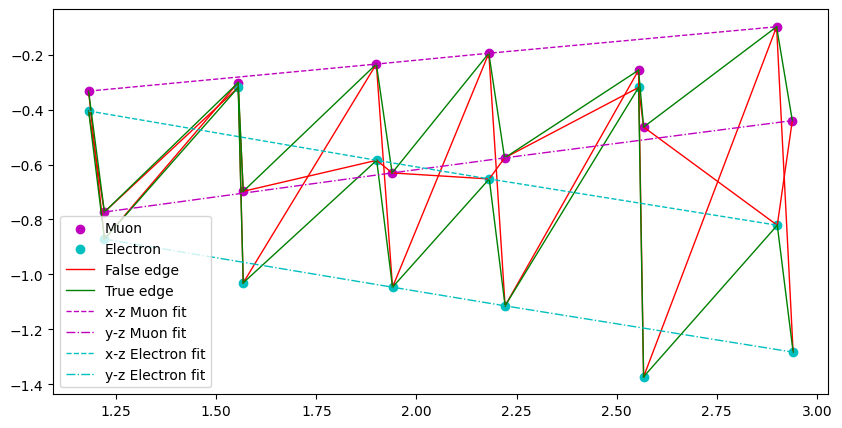

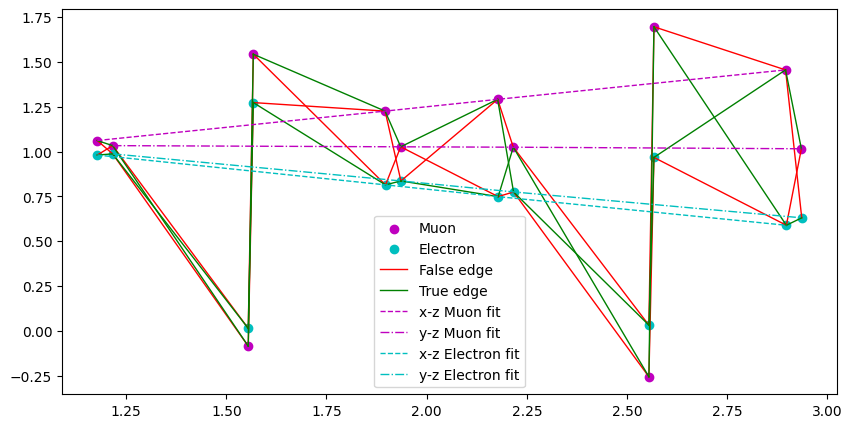

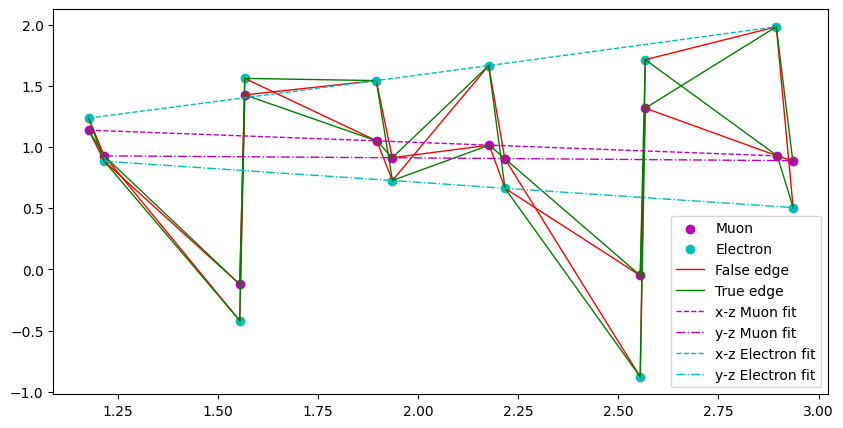

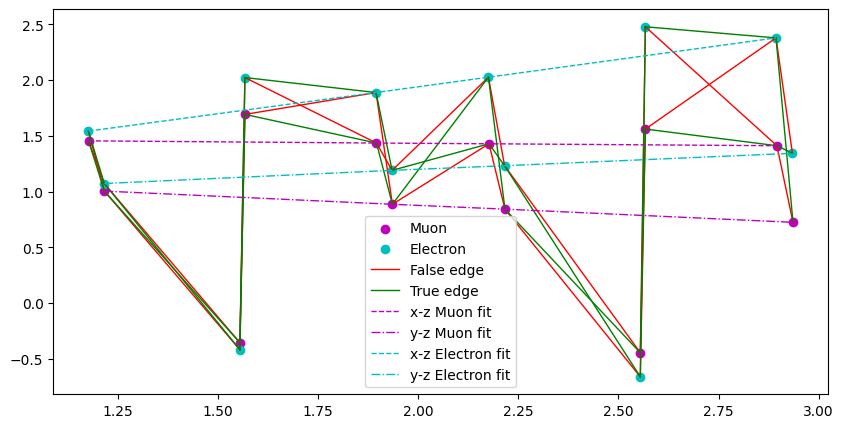

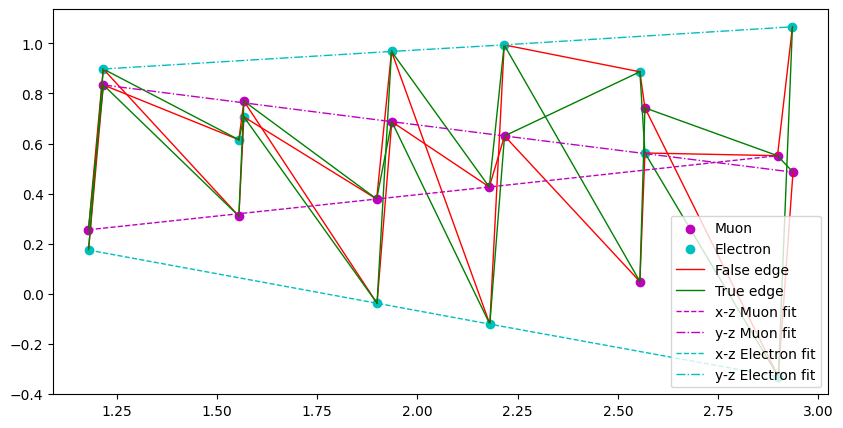

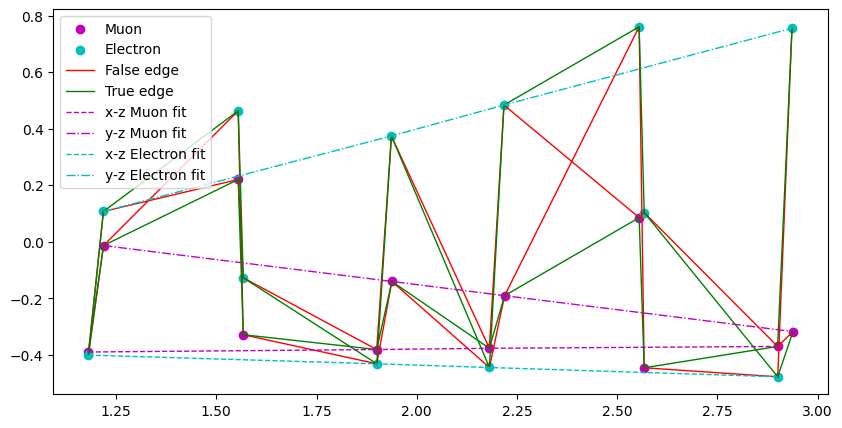

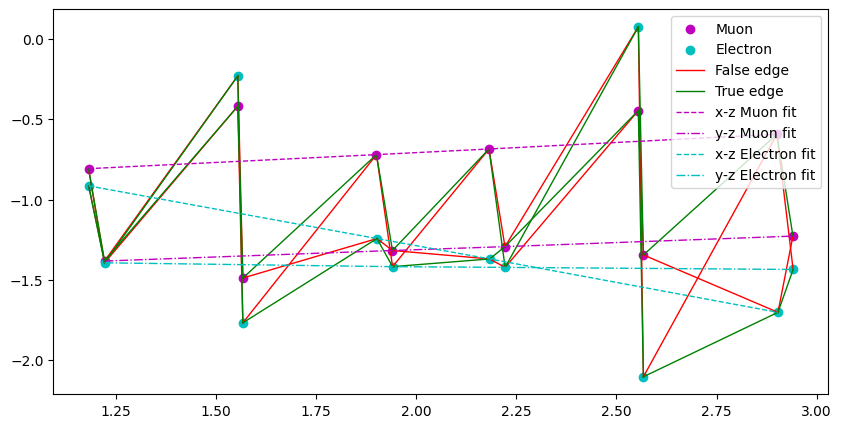

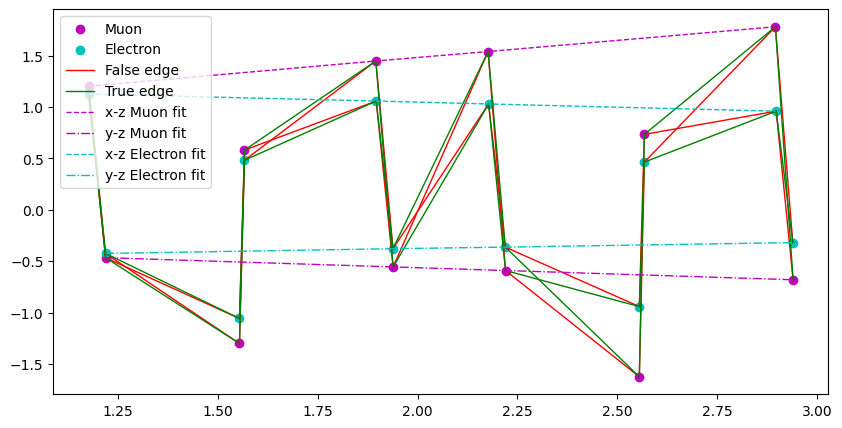

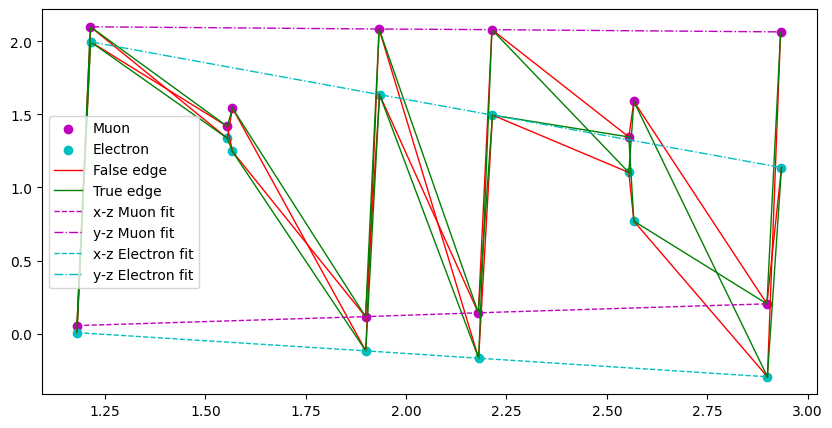

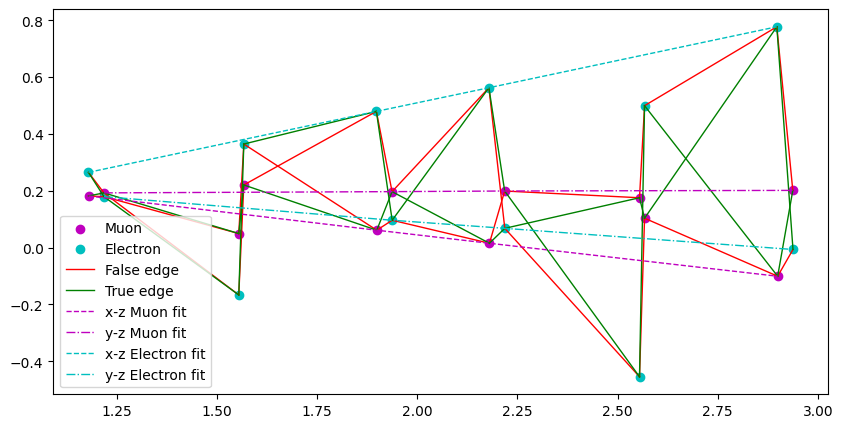

In [11]:
NUMBER_OF_EVENT_PLOTS = 10

def plot_event(event, print_data=False):
    
    if print_data:
        print("Event x:", event.x)
        print("Event edge_index:", event.edge_index)
        print("Event labels (y):", event.y)
        print("Event pid:", event.pid)
    
    plt.figure(figsize=(10, 5))
    
    x_coords = event.x[:, 0].numpy()
    y_coords = event.x[:, 1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    pid = event.pid
    
    # Plot hits
    plt.scatter(x_coords[pid == 1], y_coords[pid == 1], c='m', label='Muon')
    plt.scatter(x_coords[pid == 2], y_coords[pid == 2], c='c', label='Electron')
    
    negative_edge_indices = torch.nonzero(train_dataset[0].y[:, 0] == 1).squeeze().numpy()
    positive_edge_indices = torch.nonzero(train_dataset[0].y[:, 1] == 1).squeeze().numpy()
    
    # Plot negative edges
    plt.plot([x_coords[edges[0, negative_edge_indices[0]]], x_coords[edges[1, negative_edge_indices[0]]]],
             [y_coords[edges[0, negative_edge_indices[0]]], y_coords[edges[1, negative_edge_indices[0]]]],
             c='red', linewidth=1, label='False edge')

    plt.plot([x_coords[edges[0, negative_edge_indices[1:]]], x_coords[edges[1, negative_edge_indices[1:]]]],
             [y_coords[edges[0, negative_edge_indices[1:]]], y_coords[edges[1, negative_edge_indices[1:]]]],
             c='red', linewidth=1)
    
    # Plot positive edges
    plt.plot([x_coords[edges[0, positive_edge_indices[0]]], x_coords[edges[1, positive_edge_indices[0]]]],
             [y_coords[edges[0, positive_edge_indices[0]]], y_coords[edges[1, positive_edge_indices[0]]]],
             c='green', linewidth=1, label='True edge')

    plt.plot([x_coords[edges[0, positive_edge_indices[1:]]], x_coords[edges[1, positive_edge_indices[1:]]]],
             [y_coords[edges[0, positive_edge_indices[1:]]], y_coords[edges[1, positive_edge_indices[1:]]]],
             c='green', linewidth=1) 
    
    # Plot x-z and y-z fits
    fit_data = {
        'mu_x': ([], []),
        'mu_y': ([], []),
        'e_x':  ([], []),
        'e_y':  ([], [])
    }

    def append_fit_data(hit, label):
        fit_data[label][0].append(hit[0].item())
        fit_data[label][1].append(hit[1].item())

    for pid_val, label_prefix in zip([1, 2], ['mu', 'e']):
        for hit in event.x[pid == pid_val]:
            layer = layer_type(z_scale * hit[0].item())
            if layer in ['x', 'y']:
                append_fit_data(hit, f"{label_prefix}_{layer}")

    styles = {
        'mu_x': ('m', '--', 'x-z Muon fit'),
        'mu_y': ('m', '-.', 'y-z Muon fit'),
        'e_x':  ('c', '--', 'x-z Electron fit'),
        'e_y':  ('c', '-.', 'y-z Electron fit')
    }

    for key, (color, linestyle, label) in styles.items():
        plt.plot(fit_data[key][0], fit_data[key][1], c=color, linewidth=1, linestyle=linestyle, label=label)
    
    plt.legend()
    plt.show()

for i in range(NUMBER_OF_EVENT_PLOTS):
    plot_event(train_loader.dataset[i])

### Model build

In [9]:
def train(model, train_loader, optimizer, weight):
    correct = 0
    total = 0
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)

        loss = F.cross_entropy(pred.float(), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(axis=1) == data.y.argmax(axis=1)).sum().item()
        total += len(pred)
        
    acc = correct / total
    return acc, total_loss


def evaluate(model, test_loader, weight):
    correct = 0
    total = 0
    total_loss = 0
    
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.cross_entropy(pred.float(), data.y.float())
        total_loss += loss.item()
        correct += (pred.argmax(axis=1) == data.y.argmax(axis=1)).sum().item()
        total += len(pred)
        
    acc = correct / total
    return acc, total_loss

In [10]:
def make_mlp(
    input_size,
    sizes,
    hidden_activation='ReLU',
    output_activation='ReLU',
    layer_norm=False,
):
    '''Construct an MLP with specified fully-connected layers.'''
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
        
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    
    # Hidden layers
    for i in range(n_layers - 1):
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i + 1]))
        layers.append(hidden_activation())
        
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
        
    return nn.Sequential(*layers)


class MPNN_Network(nn.Module):
    '''
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    '''

    def __init__(
        self,
        input_dim,
        hidden_node_dim,
        hidden_edge_dim,
        in_layers,
        node_layers,
        edge_layers,
        n_graph_iters=1,
        layer_norm=True,
    ):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim] * in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(
            2 * hidden_node_dim, [hidden_edge_dim] * edge_layers, layer_norm=layer_norm
        )

        # The node network computes new node features
        self.node_network = make_mlp(
            hidden_node_dim + hidden_edge_dim,
            [hidden_node_dim] * node_layers,
            layer_norm=layer_norm,
        )

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(
            2 * hidden_node_dim, [hidden_edge_dim, 2], output_activation=None
        )

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)

        return self.edge_classifier(clf_inputs).squeeze(-1)

In [11]:
weight = 2.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 2, "hidden_node_dim": 128, "hidden_edge_dim": 256, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-5, amsgrad=True)

/home/jupyter-dmizera/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Model learning

In [12]:
EPOCHS = 500

t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

start_time = time.time()
epoch_times = []

for epoch in range(EPOCHS):
    ep += 1
    
    epoch_start_time = time.time()
    
    model.train()
    t_acc, t_total_loss = train(model, train_loader, optimizer, weight)
    t_loss_v.append(t_total_loss)
    t_acc_v.append(t_acc)

    model.eval()
    v_acc, v_total_loss = evaluate(model, test_loader, weight)
    v_loss_v.append(v_total_loss)
    v_acc_v.append(v_acc)

    epoch_end_time = time.time()
    epoch_times.append(epoch_end_time - epoch_start_time)
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    remaining_time = avg_epoch_time * (EPOCHS - (epoch + 1))
    remaining_minutes, remaining_seconds = divmod(remaining_time, 60)
    
    clear_output(wait=True)
    print(f'Epoch: {ep}, Loss: {v_total_loss:.4f}, Accuracy: {v_acc:.4f}, Time: {epoch_end_time - epoch_start_time:.2f}s, Avg. Time/Epoch: {avg_epoch_time:.2f}s, Remaining Time: {remaining_minutes:.0f}min:{remaining_seconds:.0f}s')
    
end_time = time.time()
total_training_time = end_time - start_time
total_minutes, total_seconds = divmod(total_training_time, 60)

print(f'Total Training Time: {total_minutes:.0f}min:{total_seconds:.0f}s')
print(f'Test loss and accuracy: {evaluate(model, test_loader, weight)}')

Epoch: 500, Loss: 10.6480, Accuracy: 0.9953, Time: 21.33s, Avg. Time/Epoch: 21.34s, Remaining Time: 0min:0s
Total Training Time: 177min:48s
Test loss and accuracy: (0.9952681858840217, 10.648012457735604)


In [17]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10, 5))

data = [
    (np.arange(len(t_loss_v)), t_loss_v, "Training loss"),
    (np.arange(len(t_acc_v)), t_acc_v, "Training accuracy"),
    (np.arange(len(v_loss_v)), v_loss_v, "Validation loss"),
    (np.arange(len(v_acc_v)), v_acc_v, "Validation accuracy")
]

for ax, (x, y, title) in zip(axs.ravel(), data):
    ax.plot(x, y)
    ax.set_title(title)
    ax.set_yscale("linear")
    if "accuracy" in title:
        ax.set_ylim(0, 1.05)

plt.show()

<IPython.core.display.Javascript object>

### Model save

In [12]:
model_path = './model_2025_04_12-binary.pth'

# Save the model state dictionary
# torch.save(model.state_dict(), model_path)
# print(f'Model saved to {model_path}')

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))
print(f'Model loaded from {model_path}')

Model loaded from ./model_2025_04_12-binary.pth


### Model evaluation

#### Classified events plots

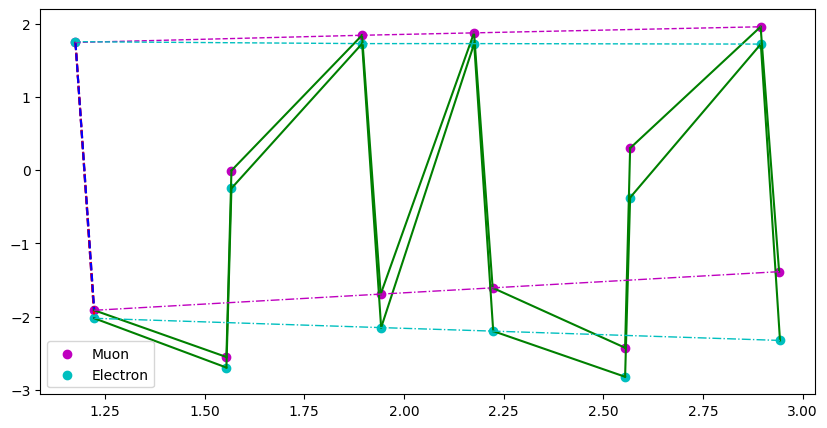

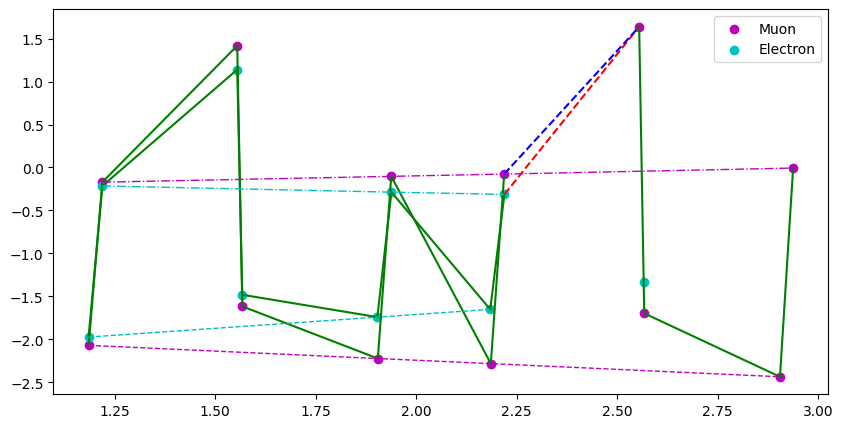

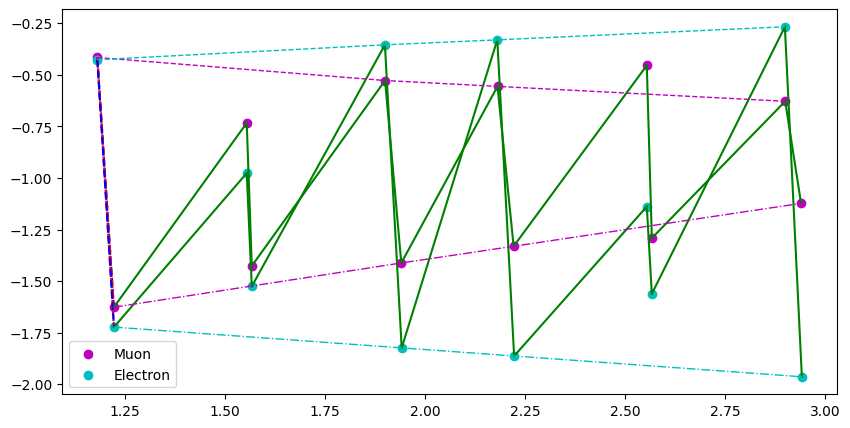

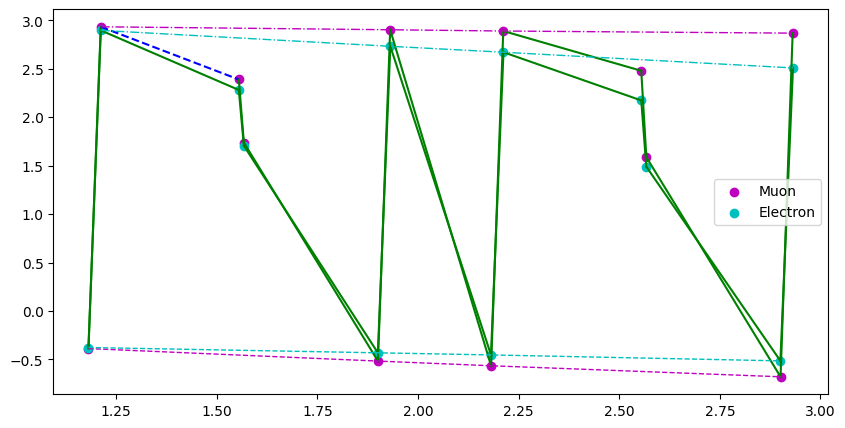

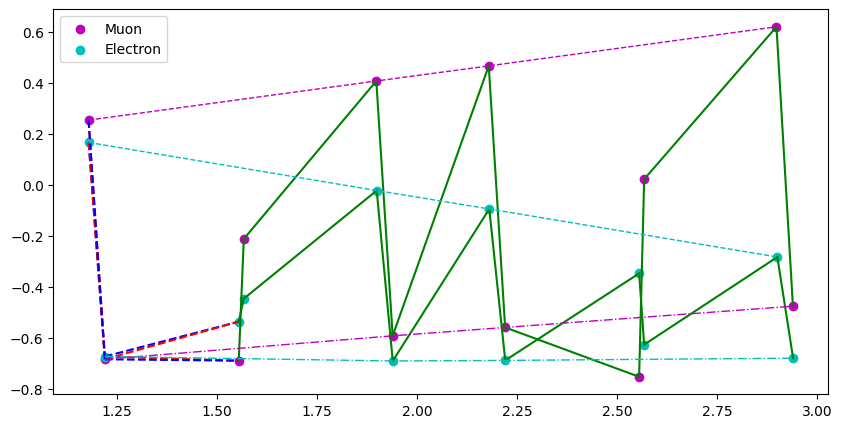

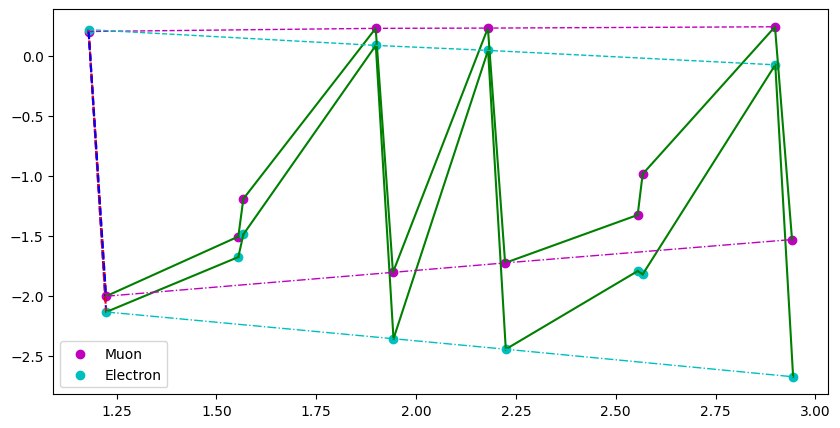

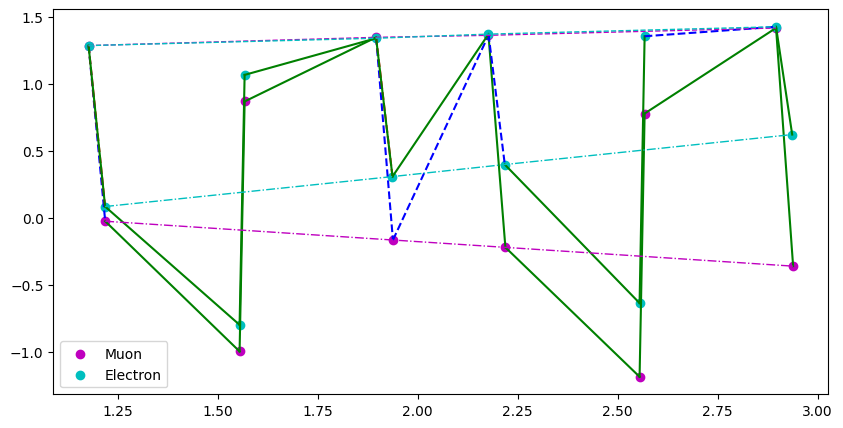

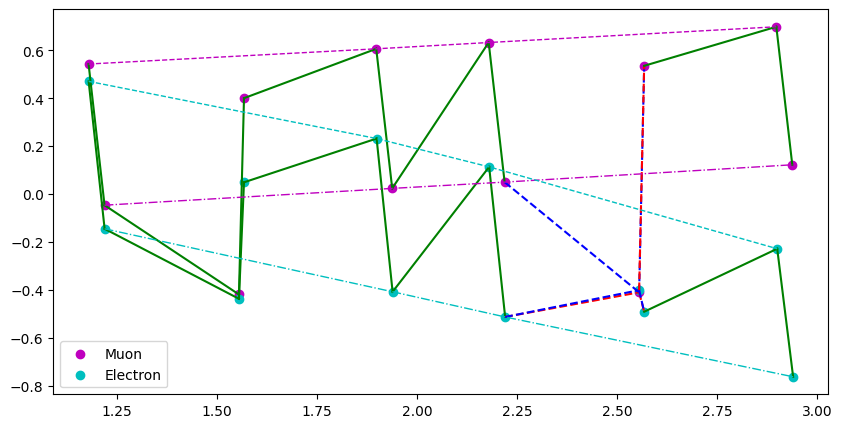

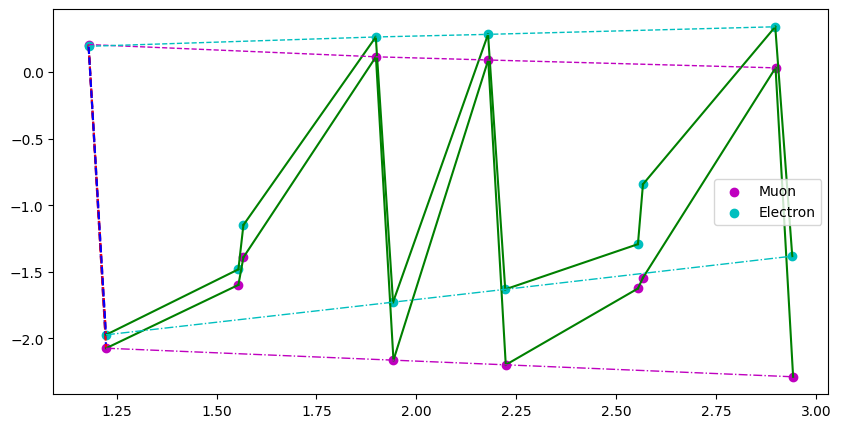

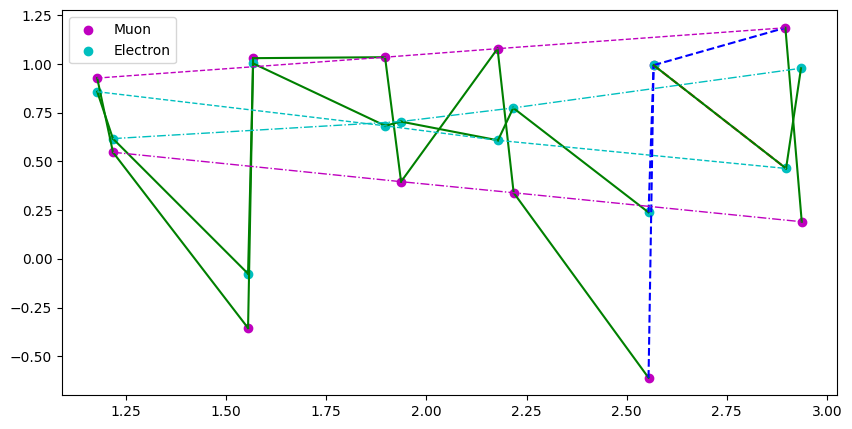

In [13]:
NUMBER_OF_CLASSIFIED_EVENT_PLOTS = 10
ERROR_ONLY = True
CUT = 0.5

def plot_classified_event(event, preds):
    
    plt.figure(figsize=(10, 5))
    
    x_coords = event.x[:, 0].numpy()
    y_coords = event.x[:, 1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    pid = event.pid
    
    # Plot hits
    plt.scatter(x_coords[pid == 1], y_coords[pid == 1], c='m', label='Muon')
    plt.scatter(x_coords[pid == 2], y_coords[pid == 2], c='c', label='Electron')
    
    # Plot classified edges
    predicted_classes = preds.argmax(axis=1)
    true_classes = labels.argmax(axis=1)
    
    for i in range(len(labels)):
        x_edge = [x_coords[edges[0, i]], x_coords[edges[1, i]]]
        y_edge = [y_coords[edges[0, i]], y_coords[edges[1, i]]]

        if predicted_classes[i] == 0 and true_classes[i] > 0:
            # False negatives
            plt.plot(x_edge, y_edge, '--', c='blue')
            
        elif predicted_classes[i] > 0 and true_classes[i] == 0:
            # False positives
            plt.plot(x_edge, y_edge, '--', c='red')
            
        elif predicted_classes[i] == 1 and true_classes[i] == 1:
            # True positives
            plt.plot(x_edge, y_edge, '-', c='green')
            
#         elif predicted_classes[i] == 0 and true_classes[i] == 0:
#             # True negatives
#             plt.plot(x_edge, y_edge, '-', c='black')
    
    # Plot x-z and y-z fits
    fit_data = {
        'mu_x': ([], []),
        'mu_y': ([], []),
        'e_x':  ([], []),
        'e_y':  ([], [])
    }

    def append_fit_data(hit, label):
        fit_data[label][0].append(hit[0].item())
        fit_data[label][1].append(hit[1].item())

    for pid_val, label_prefix in zip([1, 2], ['mu', 'e']):
        for hit in event.x[pid == pid_val]:
            layer = layer_type(z_scale * hit[0].item())
            if layer in ['x', 'y']:
                append_fit_data(hit, f"{label_prefix}_{layer}")

    styles = {
        'mu_x': ('m', '--'),
        'mu_y': ('m', '-.'),
        'e_x':  ('c', '--'),
        'e_y':  ('c', '-.')
    }

    for key, (color, linestyle) in styles.items():
        plt.plot(fit_data[key][0], fit_data[key][1], c=color, linewidth=1, linestyle=linestyle)
    
    plt.legend()
    plt.show()


# Plot a few events
events_plotted = 0
for i in range(len(test_loader.dataset)):
    event = test_loader.dataset[i].to(device)
    preds = torch.sigmoid(model(event)).to('cpu')

    if ERROR_ONLY:
        true_labels = event.y.cpu().argmax(dim=1)
        predicted_labels = preds.argmax(dim=1)
        if not torch.equal(true_labels, predicted_labels):
            plot_classified_event(event.to('cpu'), preds)
            events_plotted += 1
    else:
        plot_classified_event(event.to('cpu'), preds)
        events_plotted += 1
    
    if events_plotted >= NUMBER_OF_CLASSIFIED_EVENT_PLOTS:
        break

#### ROC curve and confusion matrix

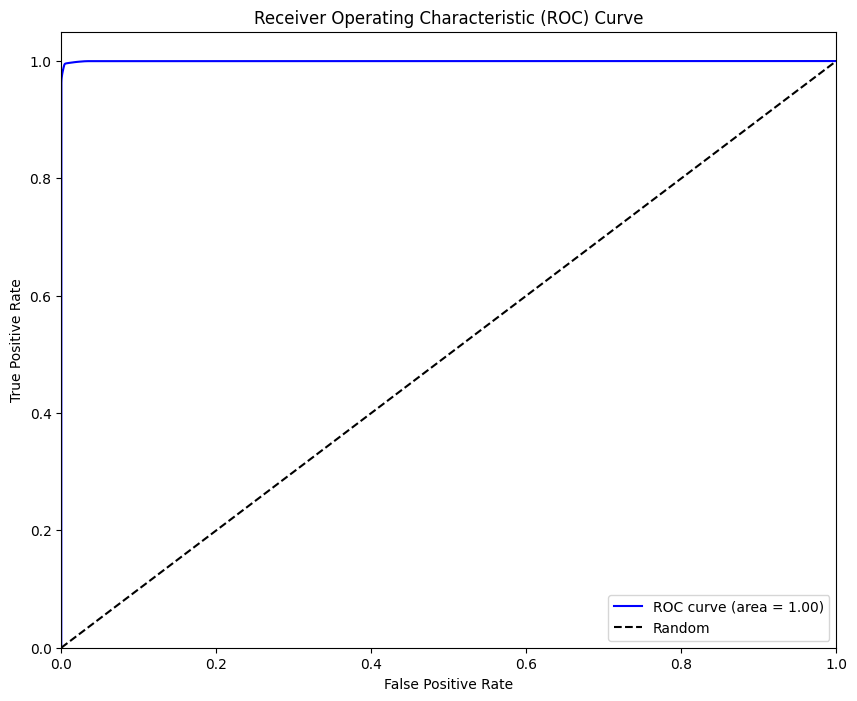

AUC: 0.999859


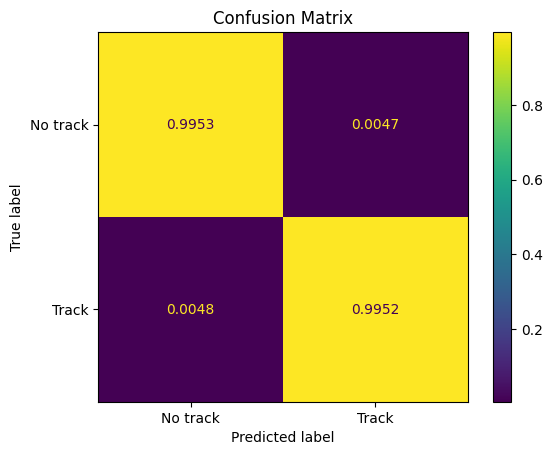

In [14]:
y_test = []
y_pred_proba = []

# Batch processing to save VRAM
model.eval()

# Need to send data to GPU needed after laoding from disk
model.to(device)
for data in test_loader.dataset:
    data.to(device)

with torch.no_grad():
    for batch in test_loader:
        inputs = batch.to(device)
        labels = batch.y.to(device).argmax(dim=1)
        
        logits = model(inputs)
        
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        
        y_pred_proba.append(probabilities.cpu())
        y_test.append(labels.cpu())

y_test = torch.cat(y_test).numpy()
y_pred_proba = torch.cat(y_pred_proba).numpy()[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()

print(f'AUC: {roc_auc:.6f}')

y_pred = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No track","Track"])
disp.plot(values_format=".4f")
plt.title('Confusion Matrix')
plt.show()

#### Fit

In [ ]:
def extract_and_plot_predicted_tracks(event, preds, incoming_hits=None, output=False):
    z_coords = z_scale * event.x[:, 0].numpy()
    x_coords = event.x[:, 1].numpy()
    edges = event.edge_index.numpy()
    predicted_classes = preds.argmax(axis=1).numpy()
    pids = event.pid.numpy()

    G = nx.Graph()
    for i in range(edges.shape[1]):
        if predicted_classes[i] == 1:
            u, v = edges[0, i], edges[1, i]
            G.add_edge(u, v)

    components = list(nx.connected_components(G))

    if len(components) != 2:
        if output:
            print(f"Event odrzucony: wykryto {len(components)} torów")
        return None

    track_candidate_1 = list(components[0])
    track_candidate_2 = list(components[1])

    slope_diffs = {1: [], 2: []}

    if output:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
        colors = ['orange', 'blue']
        labels = ['Ślad 1', 'Ślad 2']

    for idx, track in enumerate([track_candidate_1, track_candidate_2]):
        z_x_hits, x_hits = [], []
        z_y_hits, y_hits = [], []

        for i in track:
            layer = layer_type(z_coords[i])
            if layer == 'x':
                z_x_hits.append(z_coords[i])
                x_hits.append(x_coords[i])
            elif layer == 'y':
                z_y_hits.append(z_coords[i])
                y_hits.append(x_coords[i])

        if len(z_x_hits) != 4 or len(z_y_hits) != 4:
            if output:
                print("Event odrzucony: liczba punktów w tracku różna od 4")
            return None

        def slope_between_points(z1, z2, v1, v2):
            if z2 - z1 == 0:
                return float('inf')
            return (v2 - v1) / (z2 - z1)

        def fit_and_get_angle_diff(z_vals, val_hits):
            slope_1 = slope_between_points(z_vals[0], z_vals[1], val_hits[0], val_hits[1])
            slope_2 = slope_between_points(z_vals[2], z_vals[3], val_hits[2], val_hits[3])
            angle_diff_rad = np.arctan(slope_1) - np.arctan(slope_2)
            return angle_diff_rad * 1000  # w mrad

        slope_diff_x = fit_and_get_angle_diff(10*z_x_hits, x_hits)
        slope_diff_y = fit_and_get_angle_diff(10*z_y_hits, y_hits)

        track_pid = int(round(np.mean([pids[i] for i in track])))
        if track_pid in slope_diffs:
            slope_diffs[track_pid].extend([slope_diff_x, slope_diff_y])

        if output:
            def plot_segments(ax, z_vals, val_hits, color):
                # Segment 1
                z1, z2 = z_vals[0], z_vals[1]
                v1, v2 = val_hits[0], val_hits[1]
                slope = slope_between_points(z1, z2, v1, v2)
                z_fit = np.linspace(z1, z2, 50)
                v_fit = slope * (z_fit - z1) + v1
                ax.plot(z_fit, v_fit, color=color, linestyle='dashed')

                # Segment 2
                z3, z4 = z_vals[2], z_vals[3]
                v3, v4 = val_hits[2], val_hits[3]
                slope = slope_between_points(z3, z4, v3, v4)
                z_fit = np.linspace(z3, z4, 50)
                v_fit = slope * (z_fit - z3) + v3
                ax.plot(z_fit, v_fit, color=color)

            axs[0].scatter(z_x_hits, x_hits, label=labels[idx], color=colors[idx])
            plot_segments(axs[0], z_x_hits, x_hits, colors[idx])

            axs[1].scatter(z_y_hits, y_hits, label=labels[idx], color=colors[idx])
            plot_segments(axs[1], z_y_hits, y_hits, colors[idx])

    if incoming_hits and output:
        z_in_x, x_in = [], []
        z_in_y, y_in = [], []

        for hit in incoming_hits:
            z, pos, _, _ = hit
            layer = layer_type(z)
            if layer == 'x':
                z_in_x.append(z)
                x_in.append(pos)
            elif layer == 'y':
                z_in_y.append(z)
                y_in.append(pos)

        def plot_incoming_fit(ax, z_vals, val_hits, label='Mion wchodzący', color='m'):
            if len(z_vals) < 2:
                return
            z1, z2 = z_vals[0], z_vals[1]
            v1, v2 = val_hits[0], val_hits[1]
            slope = slope_between_points(z1, z2, v1, v2)
            z_fit = np.linspace(min(z_vals), max(z_vals), 50)
            v_fit = slope * (z_fit - z1) + v1
            ax.scatter(z_vals, val_hits, color=color, label=label)
            ax.plot(z_fit, v_fit, color=color)

        if len(z_in_x) >= 2:
            plot_incoming_fit(axs[0], z_in_x, x_in)
        if len(z_in_y) >= 2:
            plot_incoming_fit(axs[1], z_in_y, y_in)

    if output:
        axs[0].set_title("Rzut Z – X")
        axs[1].set_title("Rzut Z – Y")
        axs[0].set_ylabel(r"$X\ \left[\mathrm{mm}\right]$")
        axs[1].set_ylabel(r"$Y\ \left[\mathrm{mm}\right]$")
        for ax in axs:
            ax.set_xlabel(r"$Z\ \left[10^3\ \mathrm{mm}\right]$")
            ax.grid(True)
            ax.legend()
        plt.tight_layout()
        plt.show()

    return track_candidate_1, track_candidate_2, slope_diffs

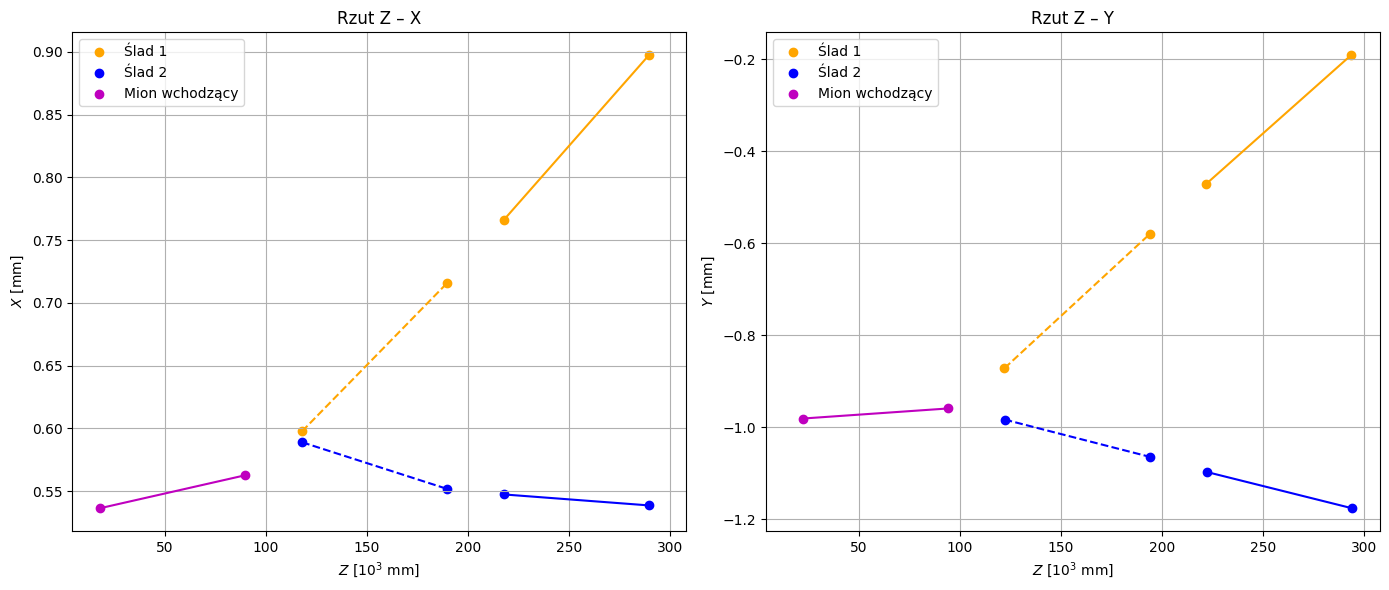

([0, 1, 2, 3, 4, 5, 12, 14, 16, 19, 20, 23],
 [6, 7, 8, 9, 10, 11, 13, 15, 17, 18, 21, 22],
 {1: [-0.3957620356231928, -0.030430383048951626],
  2: [-0.18283713143318892, 0.15252316370606422]})

In [ ]:
i = 1

event = test_loader.dataset[i].to(device)
incoming_hits = test_incoming[i]
preds = torch.sigmoid(model(event)).to('cpu')

extract_and_plot_predicted_tracks(event.to("cpu"), preds, incoming_hits, output=True)

#### Angle comparison

In [ ]:
slope_diffs_all = {
    1: {'x': [], 'y': []},
    2: {'x': [], 'y': []}
}

for i in tqdm(range(len(test_loader.dataset)), desc="Przetwarzanie eventów"):
    event = test_loader.dataset[i].to(device)
    with torch.no_grad():
        preds = torch.sigmoid(model(event)).to('cpu')

    result = extract_and_plot_predicted_tracks(event.to('cpu'), preds, output=False)

    if result is not None:
        _, _, slope_diffs = result
        for pid in [1, 2]:
            diffs = slope_diffs.get(pid, [])
            if len(diffs) == 2:
                slope_diffs_all[pid]['x'].append(diffs[0])
                slope_diffs_all[pid]['y'].append(diffs[1])

Przetwarzanie eventów: 100%|██████████| 22152/22152 [01:27<00:00, 254.26it/s]


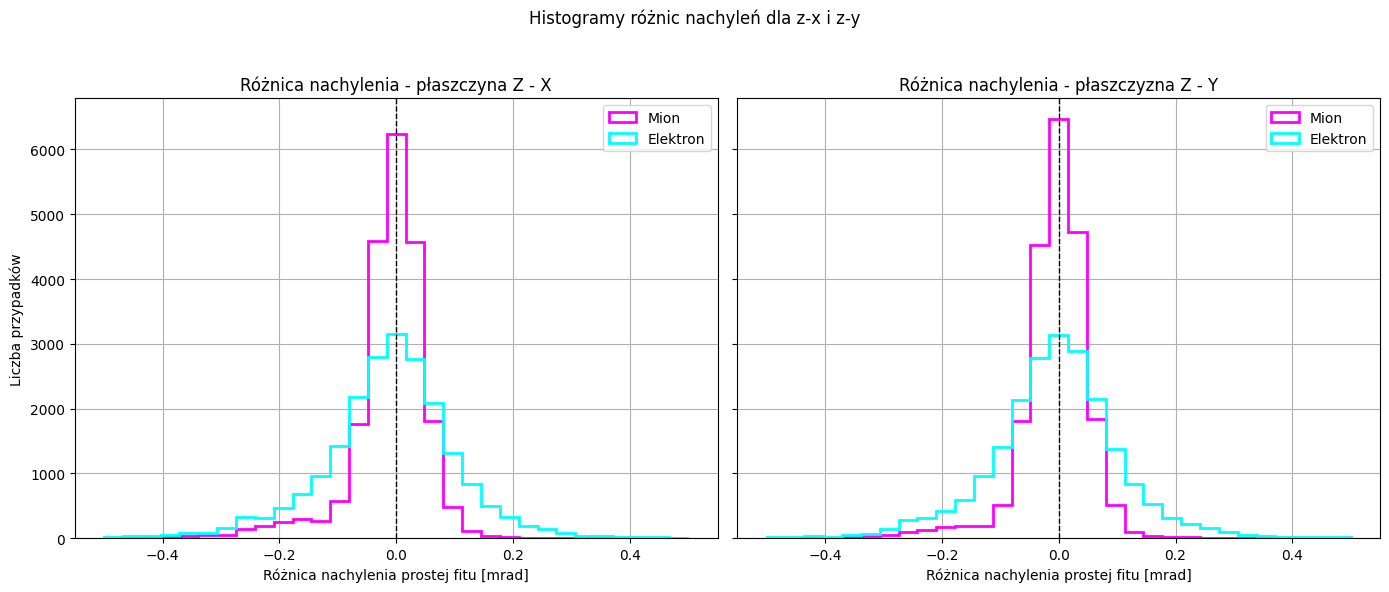

In [ ]:
all_diffs = (
    slope_diffs_all[1]['x'] + slope_diffs_all[1]['y'] +
    slope_diffs_all[2]['x'] + slope_diffs_all[2]['y']
)

min_diff = min(all_diffs)
max_diff = max(all_diffs)

bins = np.linspace(-0.5, 0.5, 32)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axs[0].hist(slope_diffs_all[1]['x'], bins=bins, color='magenta', label='Mion',
            histtype='step', linewidth=2)
axs[0].hist(slope_diffs_all[2]['x'], bins=bins, color='cyan', label='Elektron',
            histtype='step', linewidth=2)
axs[0].set_title("Różnica nachylenia - płaszczyna Z - X")
axs[0].set_xlabel("Różnica nachylenia prostej fitu [mrad]")
axs[0].set_ylabel("Liczba przypadków")
axs[0].legend()
axs[0].grid(True)
axs[0].axvline(0, color='black', linestyle='--', linewidth=1)

axs[1].hist(slope_diffs_all[1]['y'], bins=bins, color='magenta', label='Mion',
            histtype='step', linewidth=2)
axs[1].hist(slope_diffs_all[2]['y'], bins=bins, color='cyan', label='Elektron',
            histtype='step', linewidth=2)
axs[1].set_title("Różnica nachylenia - płaszczyzna Z - Y")
axs[1].set_xlabel("Różnica nachylenia prostej fitu [mrad]")
axs[1].legend()
axs[1].grid(True)
axs[1].axvline(0, color='black', linestyle='--', linewidth=1)

plt.suptitle("Histogramy różnic nachyleń dla z-x i z-y")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()